In [18]:
import os
import email
from email import policy
from pathlib import Path


def extract_email_details(mail_path: Path, attachments_folder: Path) -> dict:
    # Read the .eml file
    with open(mail_path, "rb") as f:
        msg = email.message_from_binary_file(f, policy=policy.default)
    
    sender = msg.get('From')
    reciver = msg.get('To')
    subject = msg.get('Subject')
    date = msg.get('Date')
    body = msg.get_body(preferencelist=('plain', 'html')).get_content()
    attachments = []
    
    # Extract attachments and save them
    for part in msg.iter_attachments():
        filename = part.get_filename()
        if filename:
            attachments.append(filename)
            with open(attachments_folder / filename, "wb") as f:
                f.write(part.get_payload(decode=True))
    
    return {
        "Sender": sender,
        "Reciver": reciver,
        "Subject": subject,
        "Date": date,
        "Body": body,
        "Attachments": attachments
    }

In [27]:
# Example usage
from config.settings import DATA_DIR
mails_dir = DATA_DIR / 'mails'
mail_path = mails_dir / os.listdir(mails_dir)[1]
mail_name = mail_path.name.split('.')[0]

attachments_folder = Path.cwd() / 'attachments' / mail_name

# Ensure the parent exist
attachments_folder.mkdir(exist_ok=True)

email_details = extract_email_details(mail_path, attachments_folder)

import json
json_string = json.dumps(email_details, indent =4)

from IPython.display import display, HTML, Image
from json2html import json2html

data = json2html.convert(json=json_string)
display(HTML(data))

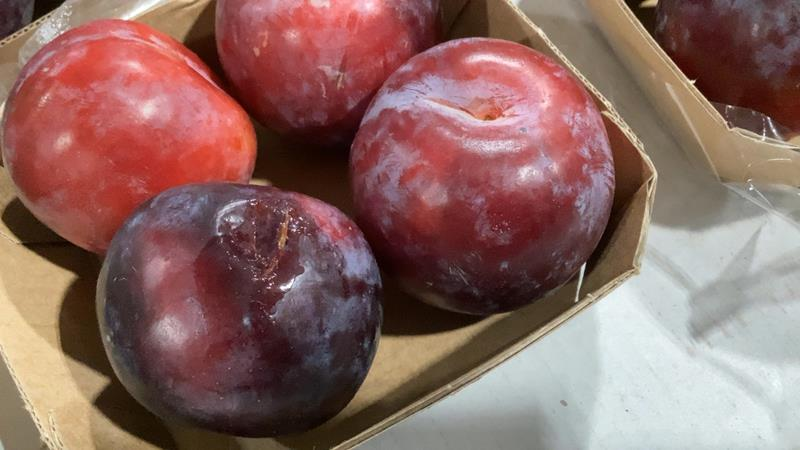

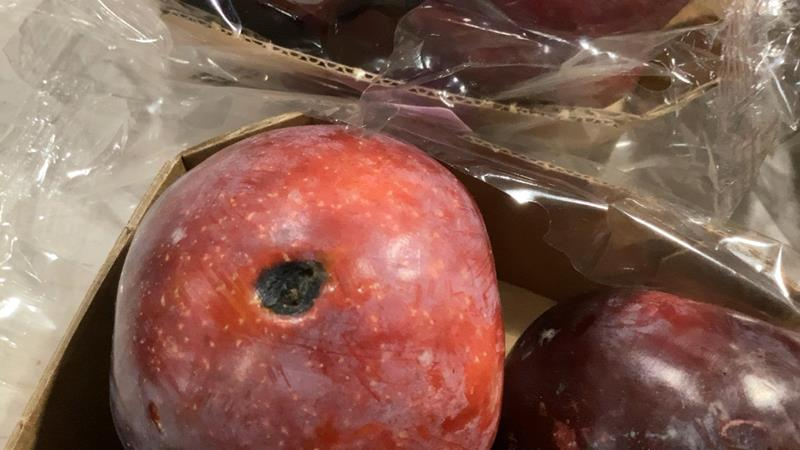

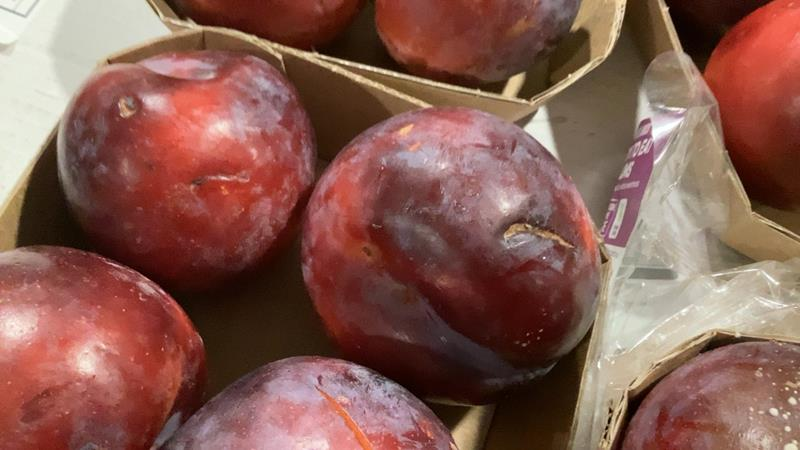

In [15]:
for attachment in email_details['Attachments'][:3]:
    if attachment.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tif', '.tiff')):
        display(Image(filename=attachments_folder / attachment, height=400, width=200))

In [28]:
print(email_details['Body'])

M&amp;S Product Quality Notification - Product Escalation

ID      7735
Notification Type       Product Escalation
Date / Time     14/08/2024 13:59
Source  FSL
Submitted By    R. Pittala
Location        RDC: Crewe
Category        Fruit - Stone Fruit
Product 00082723: YELLOW NECTARINES X4
Focus Product   No
Supplier        4793: DIRECT PRODUCE SUPPLIES
Traceability    Variety: Honey Glo
Grower: N/A
COO: Spain
Label Date Code: 2024-08-19
Product Temp: 2.8
Storage Temp: 4

Delivery Size (cases x units)   69 x 10
Cases Sampled   20
Units OOS (OOS / Sampled)       32/40
Units Removed / Destructively Tested    0
Cases Rejected  69/69
Units Rejected  690/690
Rejection Level Full
Details During the inspection of 40 packs of PR yellow nectarines (82723) from a total of 20 cases (100 packs), several issues were discovered. - 20 fruits exhibited internal breakdown and were soft. - 10 packs contained internal rots, glassy, and mushy texture. - 2 packs displayed external storage mold. The major def